In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 
from tqdm import tqdm

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

def ignore_warn(*args, **kwargs):
    pass

In [3]:
import datetime

In [4]:
data = pd.read_pickle(r'C:\Self-Learning\Kaggle\CustomerSegmentation\online retail\features.pkl')

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Yes
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Yes
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes


### RFM Model for Customer value:
<b>RFM</b>, Recency, Frequency and Monetory Value, based model model for customer value for finding out customer segments. The RFM model will take the transaction of a customer and calculate 3 important information attributes about each customer:

*  <b>Recency</b>: The value of how recently the customer purchased at the eastablishment
*  <b>Frequency</b>: How frequent the customer's transaction are at the eastablishment
*  <b>Monetary value</b>: The monetary value of all the the transactions that customer made at the eastablishment

In [6]:
reference_date = data.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date: ', reference_date)

data['days_since_last_purchase'] = (reference_date - data.InvoiceDate).astype('timedelta64[D]')
data.head()

Reference Date:  2011-12-10 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,days_since_last_purchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Yes,374.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Yes,374.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0


In [7]:
# Receny
data_history_df = data[['days_since_last_purchase', 'CustomerID']].groupby('CustomerID').min().reset_index()
data_history_df.rename(columns = {'days_since_last_purchase': 'recency'}, inplace = True)

In [8]:
data_history_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0


In [9]:
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
import seaborn as sns

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20, 7))
    
    (mu, sigma) = norm.fit(data)
    
    #Kernel Density Plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure+' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    #QQ Plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability plot (skewness: {:.6f} and Kurtosis: {:.6f})'.format(data.skew(), data.kurt()), loc='center')
    
    
    
    plt.tight_layout()
    plt.show()
    

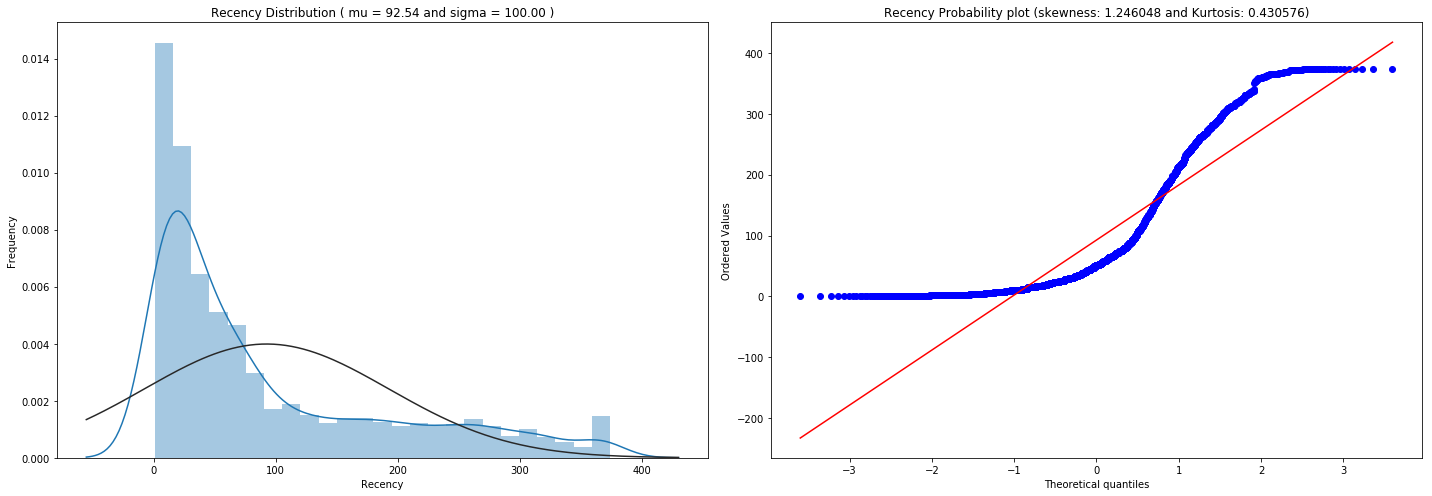

In [10]:
QQ_plot(data_history_df.recency, 'Recency')

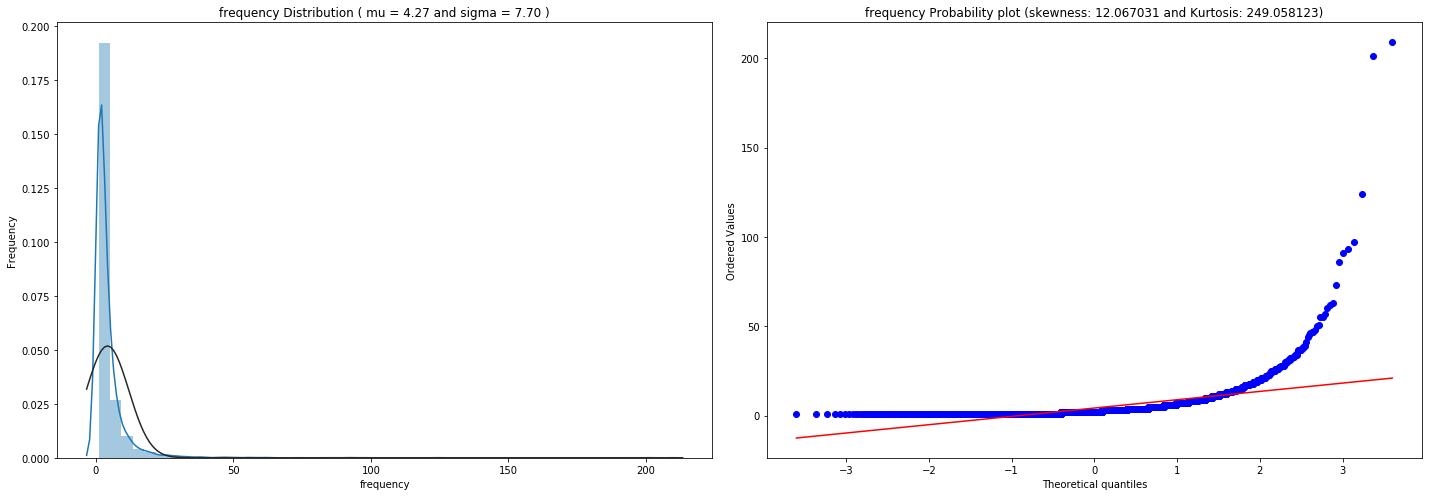

In [11]:
# Frequency
cutomer_freq = data[['CustomerID', 'InvoiceNo']].groupby(['CustomerID', 'InvoiceNo'])\
                    .count().reset_index().groupby(['CustomerID']).count().reset_index()
cutomer_freq.rename(columns = {'InvoiceNo':'frequency'}, inplace=True)
data_history_df = data_history_df.merge(cutomer_freq)
QQ_plot(data_history_df.frequency, 'frequency')

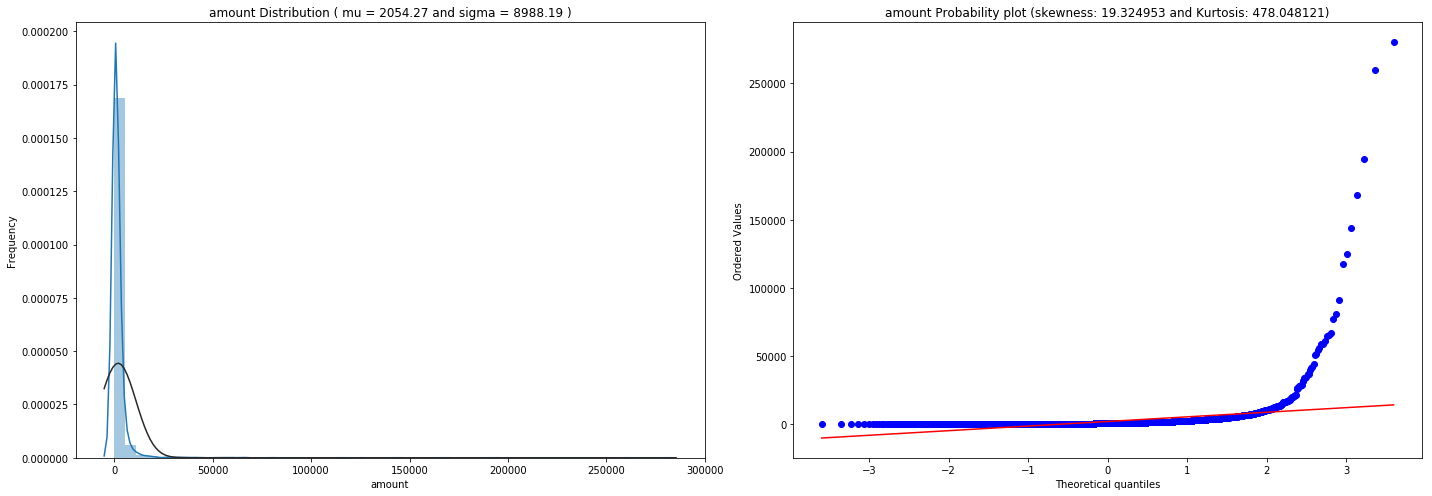

In [12]:
# Monetary value
cutomer_spend = data[['CustomerID', 'amount']].groupby(['CustomerID']).sum().reset_index()
data_history_df = data_history_df.merge(cutomer_spend)
QQ_plot(data_history_df.amount, 'amount')

In [13]:
data_history_df.describe()

,CustomerID,recency,frequency,amount
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


In [14]:
import math
from sklearn.preprocessing import StandardScaler

In [15]:
data_history_df['recency_log'] = data_history_df['recency'].apply(math.log)
data_history_df['frequency_log'] = data_history_df['frequency'].apply(math.log)
data_history_df['amount_log'] = data_history_df['amount'].apply(math.log)

feature_vector = ['recency_log', 'frequency_log', 'amount_log']

X_subset = data_history_df[feature_vector]
scaler = StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
recency_log,4338.0,-1.048288e-16,1.000115,-2.630445,-0.612424,0.114707,0.829652,1.505796
frequency_log,4338.0,-9.991495e-17,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714
amount_log,4338.0,-7.010426e-16,1.000115,-4.179280,-0.684183,-0.060942,0.654244,4.721395


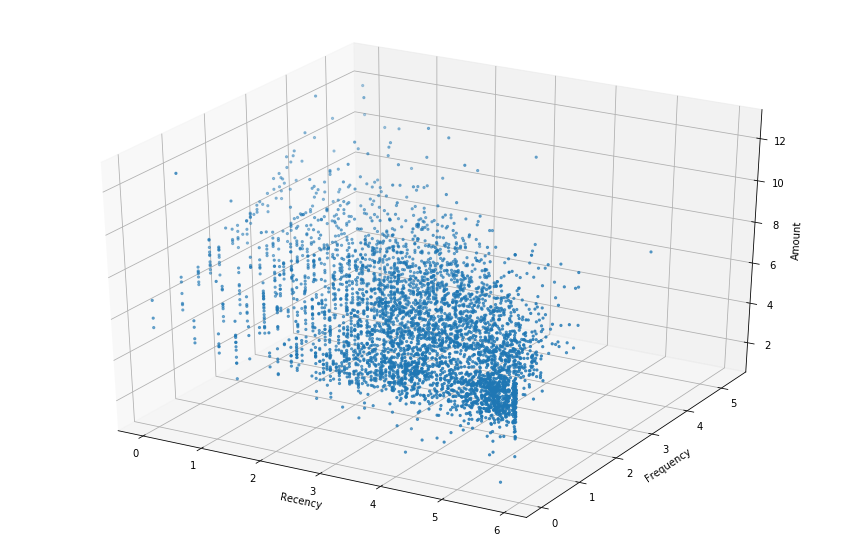

In [16]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection ="3d")

xs = data_history_df.recency_log
ys = data_history_df.frequency_log
zs = data_history_df.amount_log
ax.scatter3D(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Amount')

plt.show()

The obvious patterns we can see from the plots above is that costumers who buy with a higher frequency and more recency tend to spend more based on the increasing trend in Monetary (amount value) with a corresponding increasing and decreasing trend for Frequency and Recency, respectively.

In [17]:
from sklearn.cluster import KMeans

def clustering(k_upto, data=X_scaled):
    
    cl = k_upto
    corte = 0.1
    anterior = 100000000000000
    cost = [] 
    K_best = cl
    
    for k in tqdm(range(1, cl+1)):
        model = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42)
        model.fit(data)
        
        # Sum of distances of samples to their closest cluster center
        interia = model.inertia_
        if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
        cost.append(interia)
        anterior = interia
        
    
    return K_best, cost

In [18]:
K_best, cost = clustering(50, X_scaled)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


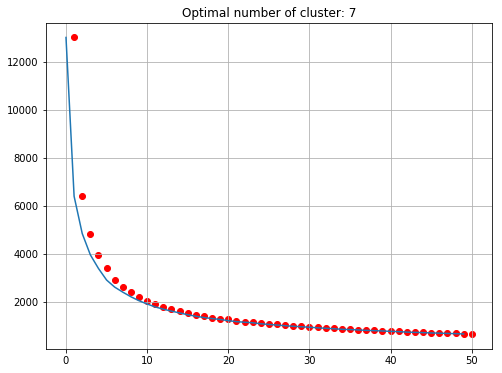

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(range(1, 51), cost, c='red')
plt.plot(cost, linestyle='-')
plt.title('Optimal number of cluster: {}'.format(K_best))
plt.grid()
plt.show()

Through <b>Elbow Method</b>, we have evaluated optimum number of clusters to be <b>7</b> after which change in inertia is less than 10%

In [22]:
# Fit the model with the best K value

model = KMeans(n_clusters=K_best, init='k-means++', max_iter=300, random_state=42)
model.fit(X_scaled)
labels = model.labels_

In [40]:
X_subset

,recency_log,frequency_log,amount_log
0,5.786897,0.000000,11.253942
1,0.693147,1.945910,8.368693
2,4.317488,1.386294,7.494007
3,2.944439,0.000000,7.471676
4,5.736572,0.000000,5.812338
...,...,...,...
4333,5.627621,0.000000,5.196285
4334,5.198497,0.000000,4.392224
4335,2.079442,0.693147,5.182064
4336,1.386294,2.772589,7.647252


In [38]:
data_history_df['cluster'] = model.labels_

In [43]:
data_history_df.head()

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,cluster
0,12346,326.0,1,77183.60,5.786897,0.000000,11.253942,2
1,12347,2.0,7,4310.00,0.693147,1.945910,8.368693,5
2,12348,75.0,4,1797.24,4.317488,1.386294,7.494007,2
3,12349,19.0,1,1757.55,2.944439,0.000000,7.471676,0
4,12350,310.0,1,334.40,5.736572,0.000000,5.812338,4


In [37]:
from matplotlib.lines import Line2D

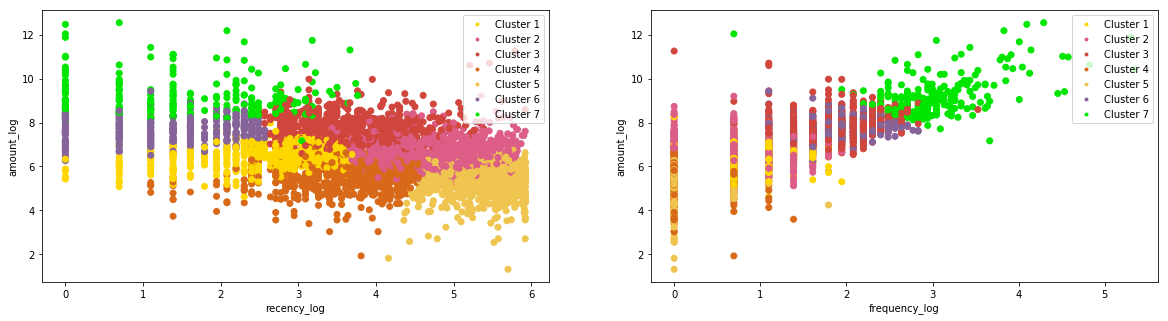

In [60]:
# Visualize Clusters

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
colors = ['#ffd700', '#dc5d86', '#d0463c', '#d86918', '#efc54f', '#866399', '#00e600']
data_history_df['c'] = data_history_df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5], 6:colors[6]})

scatter = plt.scatter(x = data_history_df.recency_log, y= data_history_df.amount_log, c=data_history_df.c)

# create a list of legend elemntes
## markers / records

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1),
                          markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
# plot legend
plt.legend(handles=legend_elements, loc='upper right')
ax.set_xlabel(feature_vector[0])
ax.set_ylabel(feature_vector[2])

ax = fig.add_subplot(122)
plt.scatter(x = data_history_df.frequency_log, y= data_history_df.amount_log, c=data_history_df.c)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1),
                          markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
# plot legend
plt.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[2])

plt.show()

Let's see below how our data perform for each K clusters groups (3, 5 and 7) in the silhouette score of each cluster, along with the center of each of the cluster discovered in the scatter plots, by amount_log vs recency_log and vs frequency_log.

In [64]:
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm

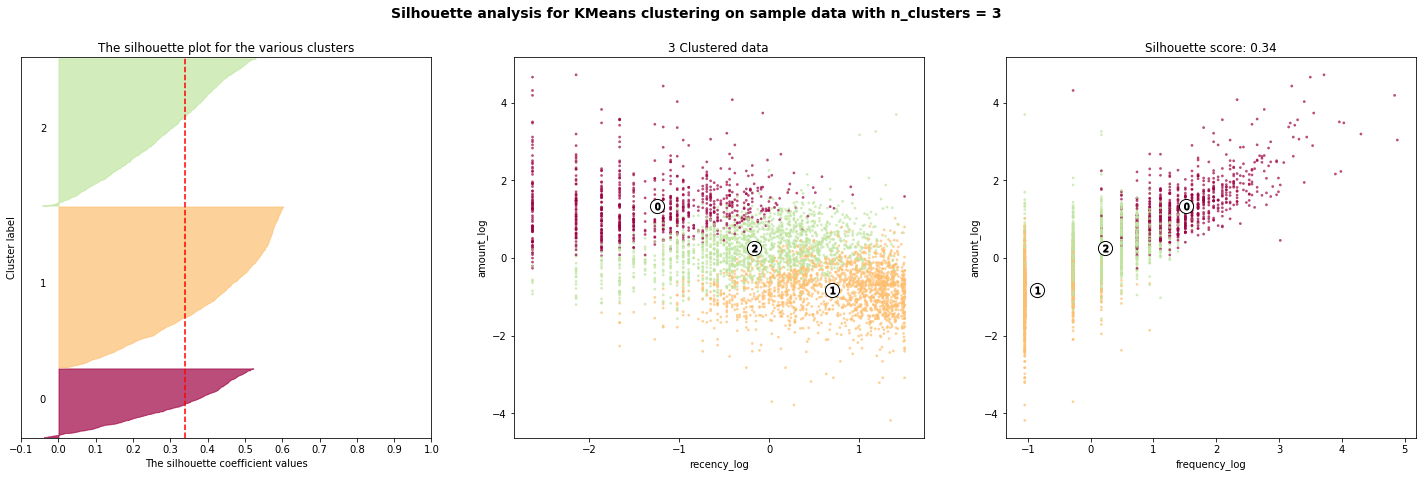

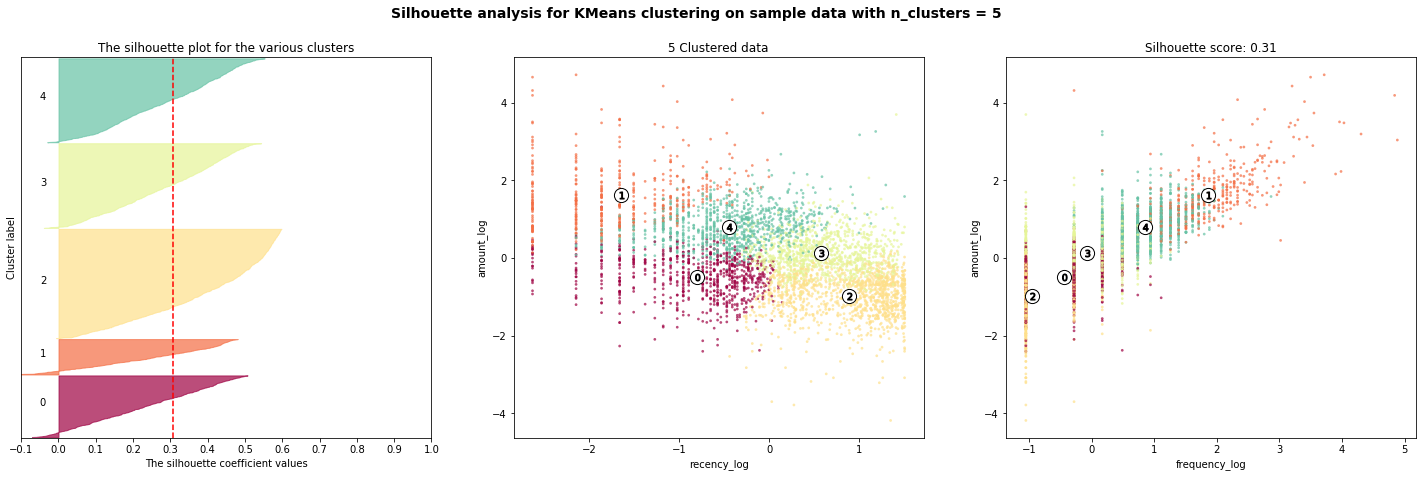

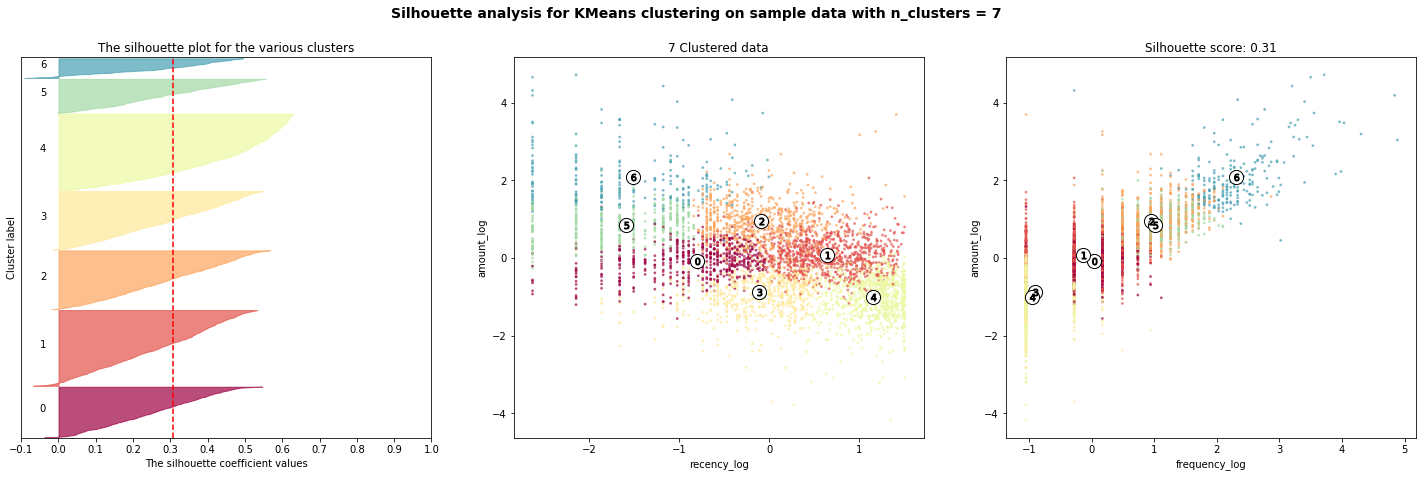

In [68]:
cluster_centers = dict()

for n_clusters in range(3, K_best+1, 2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters+1)*10 ])
    
    clusterer = KMeans(init='k-means++', n_clusters=n_clusters, max_iter=300, random_state=42)
    cluster_labels = clusterer.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X = X_scaled, labels=cluster_labels)
    cluster_centers.update({n_clusters:{
      'cluster_centers': clusterer.cluster_centers_,
      'silhouette_score': silhouette_avg,
      'labels': cluster_labels,
    }})
    
    sample_silhoutte_values = silhouette_samples(X = X_scaled, labels=cluster_labels)
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhoutte_value = sample_silhoutte_values[cluster_labels == i]
        ith_cluster_silhoutte_value.sort()
        size_cluster_i = ith_cluster_silhoutte_value.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.Spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhoutte_value,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 2
    x = 0
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])
    
    x = 1
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [74]:
clusters_df = data_history_df.copy()

In [76]:
clusters_df.columns

Index(['CustomerID', 'recency', 'frequency', 'amount', 'recency_log',
       'frequency_log', 'amount_log', 'cluster', 'c'],
      dtype='object')

In [77]:
clusters_df = clusters_df.drop(['cluster', 'c'], axis=1)
clusters_df

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log
0,12346,326.0,1,77183.60,5.786897,0.000000,11.253942
1,12347,2.0,7,4310.00,0.693147,1.945910,8.368693
2,12348,75.0,4,1797.24,4.317488,1.386294,7.494007
3,12349,19.0,1,1757.55,2.944439,0.000000,7.471676
4,12350,310.0,1,334.40,5.736572,0.000000,5.812338
...,...,...,...,...,...,...,...
4333,18280,278.0,1,180.60,5.627621,0.000000,5.196285
4334,18281,181.0,1,80.82,5.198497,0.000000,4.392224
4335,18282,8.0,2,178.05,2.079442,0.693147,5.182064
4336,18283,4.0,16,2094.88,1.386294,2.772589,7.647252


In [78]:
clusters_df['clusters_3'] = cluster_centers[3]['labels']
clusters_df['clusters_5'] = cluster_centers[5]['labels']
clusters_df['clusters_7'] = cluster_centers[7]['labels']

In [79]:
clusters_df

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_3,clusters_5,clusters_7
0,12346,326.0,1,77183.60,5.786897,0.000000,11.253942,2,3,2
1,12347,2.0,7,4310.00,0.693147,1.945910,8.368693,0,1,5
2,12348,75.0,4,1797.24,4.317488,1.386294,7.494007,2,3,2
3,12349,19.0,1,1757.55,2.944439,0.000000,7.471676,2,0,0
4,12350,310.0,1,334.40,5.736572,0.000000,5.812338,1,2,4
...,...,...,...,...,...,...,...,...,...,...
4333,18280,278.0,1,180.60,5.627621,0.000000,5.196285,1,2,4
4334,18281,181.0,1,80.82,5.198497,0.000000,4.392224,1,2,4
4335,18282,8.0,2,178.05,2.079442,0.693147,5.182064,2,0,0
4336,18283,4.0,16,2094.88,1.386294,2.772589,7.647252,0,1,5


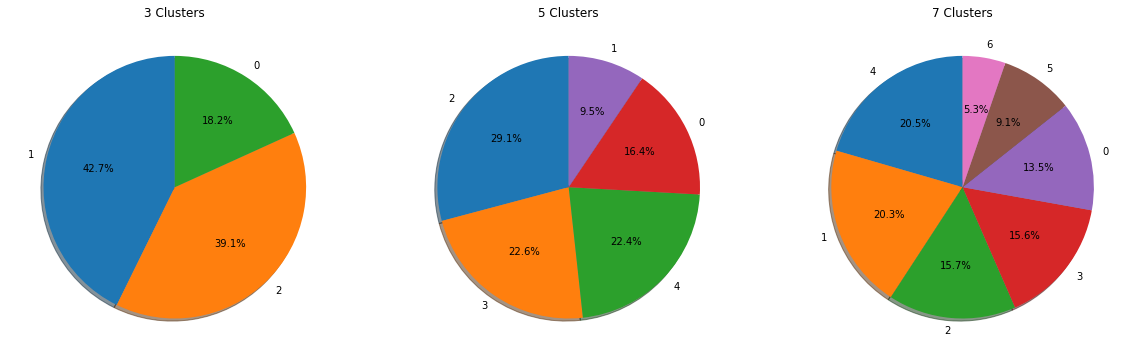

In [86]:
fig = plt.figure(figsize=(20, 7))
f1 = fig.add_subplot(131)
market = clusters_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90) 
plt.title('3 Clusters')

f1 = fig.add_subplot(132)
market = clusters_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90) 
plt.title('5 Clusters')


f1 = fig.add_subplot(133)
market = clusters_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90) 
plt.title('7 Clusters')

plt.show()

In [88]:
clusters_df.to_pickle(r'C:\Self-Learning\Kaggle\CustomerSegmentation\online retail\cluster.pkl')